In [1]:
import pandas as pd

In [3]:
merged_df = pd.read_csv('merged.csv')

In [7]:
import statsmodels.api as sm

# Define the dependent and independent variables for the regression
X = merged_df['Trump']  # Trump's winning odds
Y = merged_df['USDEUR']  # USDEUR exchange rate

# Add a constant to the independent variable (required for OLS regression)
X = sm.add_constant(X)

# Perform the OLS regression
model = sm.OLS(Y, X).fit(cov_type='HC2')

# Get the summary of the regression results
regression_summary = model.summary()

# Display the regression summary to the user
regression_summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 USDEUR   R-squared:                       0.304
Model:                            OLS   Adj. R-squared:                  0.292
Method:                 Least Squares   F-statistic:                     39.52
Date:                Wed, 23 Oct 2024   Prob (F-statistic):           3.84e-08
Time:                        19:24:21   Log-Likelihood:                 214.50
No. Observations:                  63   AIC:                            -425.0
Df Residuals:                      61   BIC:                            -420.7
Df Model:                           1                                         
Covariance Type:                  HC2                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8328      0.012     67.148      0.000       0.808       0.857
Trump          0.1532      0.024      6.286      0.000       0.105       0.201
==============================================================================
Omnibus:                        3.230   Durbin-Watson:                   0.254
Prob(Omnibus):                  0.199   Jarque-Bera (JB):                3.077
Skew:                           0.482   Prob(JB):                        0.215
Kurtosis:                       2.509   Cond. No.                         35.9
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC2)
"""

In [8]:
# Let's introduce a nonlinear term by squaring Trump's odds (i.e., testing for a quadratic relationship)
merged_df['Trump_squared'] = merged_df['Trump'] ** 2

# Define the independent variables for the nonlinear regression (Trump and Trump_squared)
X_nonlinear = merged_df[[ 'Trump_squared']]
X_nonlinear = sm.add_constant(X_nonlinear)

# Perform the OLS regression with the nonlinear term
nonlinear_model = sm.OLS(Y, X_nonlinear).fit()

# Get the summary of the nonlinear regression results
nonlinear_regression_summary = nonlinear_model.summary()

# Display the nonlinear regression summary to the user
nonlinear_regression_summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 USDEUR   R-squared:                       0.312
Model:                            OLS   Adj. R-squared:                  0.300
Method:                 Least Squares   F-statistic:                     27.63
Date:                Wed, 23 Oct 2024   Prob (F-statistic):           1.98e-06
Time:                        19:25:44   Log-Likelihood:                 214.87
No. Observations:                  63   AIC:                            -425.7
Df Residuals:                      61   BIC:                            -421.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.8709      0.007    121.900      0.000       0.857       0.885
Trump_squared     0.1531      0.029      5.257      0.000       0.095       0.211
==============================================================================
Omnibus:                        3.382   Durbin-Watson:                   0.257
Prob(Omnibus):                  0.184   Jarque-Bera (JB):                3.251
Skew:                           0.504   Prob(JB):                        0.197
Kurtosis:                       2.529   Cond. No.                         30.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

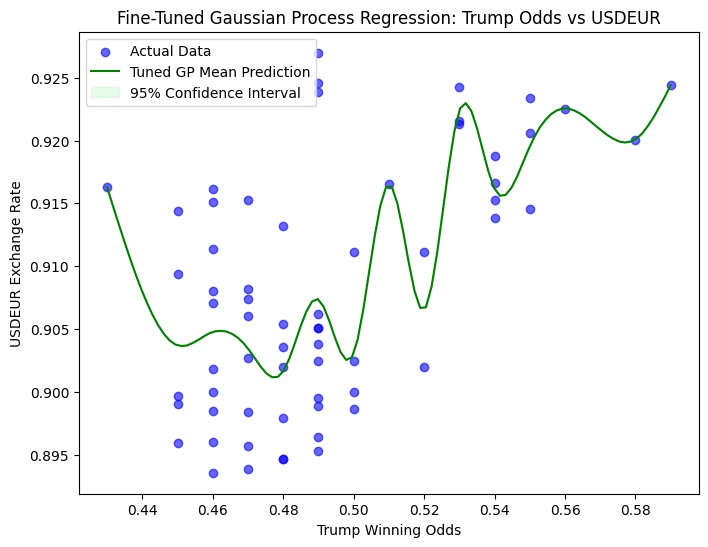

In [27]:
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process.kernels import Matern
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
import numpy as np
import matplotlib.pyplot as plt


# Prepare the data for Gaussian Process Regression
X_gp = merged_df[['Trump']].values  # Trump odds as independent variable
Y_gp = merged_df['USDEUR'].values  # USDEUR as dependent variable

X_test = np.linspace(min(merged_df['Trump']), max(merged_df['Trump']), 100).reshape(-1, 1)

# Scale the data
scaler = StandardScaler()
X_gp_scaled = scaler.fit_transform(X_gp)

# Define a new kernel: Matern kernel is a popular choice that is more flexible than RBF
kernel_tuned = C(1.0, (1e-4, 1e2)) * Matern(length_scale=1.0, length_scale_bounds=(1e-4, 1e2), nu=1.5)

gp_tuned = GaussianProcessRegressor(kernel=kernel_tuned, n_restarts_optimizer=20, normalize_y=True)
gp_tuned.fit(X_gp_scaled, Y_gp)


# Re-scale the test data for predictions
X_test_scaled = scaler.transform(X_test)

# Make predictions on the re-scaled test data
y_pred_tuned, y_std_tuned = gp_tuned.predict(X_test_scaled, return_std=True)

# Plot the results
plt.figure(figsize=(8, 6))

# Scatter plot of actual data
plt.scatter(X_gp, Y_gp, label='Actual Data', color='blue', alpha=0.6)

# Plot the mean prediction of the tuned model
plt.plot(X_test, y_pred_tuned, label='Tuned GP Mean Prediction', color='green')

# Shade the uncertainty (confidence interval) for the tuned model
plt.fill_between(X_test.ravel(), y_pred_tuned - 1.96 * y_std_tuned, y_pred_tuned + 1.96 * y_std_tuned, alpha=0.2, color='lightgreen', label='95% Confidence Interval')

# Add labels and legend
plt.xlabel("Trump Winning Odds")
plt.ylabel("USDEUR Exchange Rate")
plt.title("Fine-Tuned Gaussian Process Regression: Trump Odds vs USDEUR")
plt.legend()

# Display the plot
plt.show()


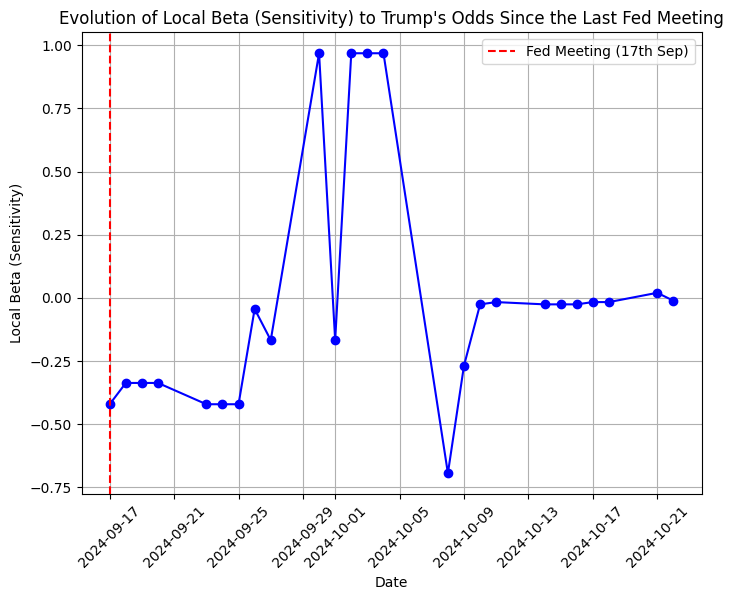

In [54]:
from scipy.optimize import approx_fprime

# Compute local beta and gamma
def compute_local_sensitivity(model, X):
    """Function to compute first and second derivatives for sensitivity analysis."""
    def model_predict(X_point):
        return model.predict(X_point.reshape(1, -1))[0]
    
    # Compute local beta (first derivative)
    local_betas = np.zeros(X.shape[0])
    for i in range(X.shape[0]):
        local_betas[i] = approx_fprime(X[i], model_predict, epsilon=1e-5)
    
    # Compute local gamma (second derivative) as the gradient of beta
    local_gammas = np.gradient(local_betas)
    return local_betas, local_gammas

# Compute local beta and gamma values for the full dataset
X_test_scaled = scaler.transform(merged_df[['Trump']].values)
local_betas, local_gammas = compute_local_sensitivity(gp_tuned, X_test_scaled)
merged_df['Local_Beta'] = local_betas
merged_df['Local_Gamma'] = local_gammas

# Average local beta and gamma values
avg_beta = merged_df['Local_Beta'].mean()
avg_gamma = merged_df['Local_Gamma'].mean()


# Ensure all dates are properly converted to datetime
merged_df['Date'] = pd.to_datetime(merged_df['Date'], errors='coerce')


# Identify the Fed meeting date
fed_meeting_date = pd.to_datetime("2024-09-17")

# Filter data for pre- and post-Fed meeting periods
pre_fed_meeting_df = merged_df[merged_df['Date'] < fed_meeting_date].copy()
post_fed_meeting_df = merged_df[merged_df['Date'] >= fed_meeting_date].copy()

# Compute local beta and gamma for post-Fed period
X_gp_post_fed = scaler.transform(post_fed_meeting_df[['Trump']].values)
local_betas_post_fed, _ = compute_local_sensitivity(gp_tuned, X_gp_post_fed)
local_gammas_post_fed = np.gradient(local_betas_post_fed)
post_fed_meeting_df['Local_Beta'] = local_betas_post_fed
post_fed_meeting_df['Local_Gamma'] = local_gammas_post_fed

# Compute local beta and gamma for pre-Fed period
X_gp_pre_fed = scaler.transform(pre_fed_meeting_df[['Trump']].values)
local_betas_pre_fed, local_gammas_pre_fed = compute_local_sensitivity(gp_tuned, X_gp_pre_fed)
pre_fed_meeting_df['Local_Beta'] = local_betas_pre_fed
pre_fed_meeting_df['Local_Gamma'] = local_gammas_pre_fed

# Calculate averages for pre- and post-Fed periods
avg_beta_pre_fed = pre_fed_meeting_df['Local_Beta'].mean()
avg_gamma_pre_fed = pre_fed_meeting_df['Local_Gamma'].mean()
avg_beta_post_fed = post_fed_meeting_df['Local_Beta'].mean()
avg_gamma_post_fed = post_fed_meeting_df['Local_Gamma'].mean()

# Output the average results
avg_beta_pre_fed, avg_gamma_pre_fed, avg_beta_post_fed, avg_gamma_post_fed

# Plot beta changes over time after the Fed meeting
plt.figure(figsize=(8, 6))
plt.plot(post_fed_meeting_df['Date'], post_fed_meeting_df['Local_Beta'], marker='o', linestyle='-', color='blue')
plt.axvline(fed_meeting_date, color='red', linestyle='--', label='Fed Meeting (17th Sep)')
plt.xlabel("Date")
plt.ylabel("Local Beta (Sensitivity)")
plt.title("Evolution of Local Beta (Sensitivity) to Trump's Odds Since the Last Fed Meeting")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [45]:
avg_beta_pre_fed, avg_gamma_pre_fed, avg_beta_post_fed, avg_gamma_post_fed

(-0.5421097094200855,
 0.21580485066904576,
 -0.47210514413960275,
 -0.1828775094869382)

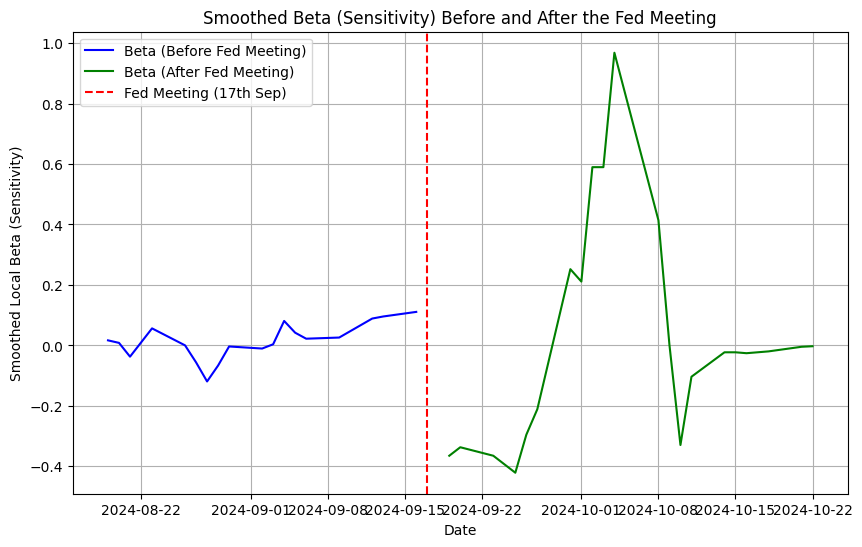

In [46]:
# Identify the Fed meeting date
fed_meeting_date = pd.to_datetime("2024-09-17")

# Filter data for pre- and post-Fed meeting periods
pre_fed_meeting_df = merged_df[merged_df['Date'] < fed_meeting_date].copy()
post_fed_meeting_df = merged_df[merged_df['Date'] >= fed_meeting_date].copy()

# Apply a rolling mean to smooth the local beta values (let's use a 5-day window as an example)
window_size = 18
window = 3
pre_fed_meeting_df['Smoothed_Beta'] = pre_fed_meeting_df['Local_Beta'].rolling(window=window_size).mean()
post_fed_meeting_df['Smoothed_Beta'] = post_fed_meeting_df['Local_Beta'].rolling(window=window).mean()

# Plot the smoothed beta values before and after the Fed meeting
plt.figure(figsize=(10, 6))

# Plot pre-Fed meeting beta values
plt.plot(pre_fed_meeting_df['Date'], pre_fed_meeting_df['Smoothed_Beta'], label='Beta (Before Fed Meeting)', color='blue')

# Plot post-Fed meeting beta values
plt.plot(post_fed_meeting_df['Date'], post_fed_meeting_df['Smoothed_Beta'], label='Beta (After Fed Meeting)', color='green')

# Highlight the Fed meeting date
plt.axvline(fed_meeting_date, color='red', linestyle='--', label='Fed Meeting (17th Sep)')

# Add labels and legend
plt.xlabel("Date")
plt.ylabel("Smoothed Local Beta (Sensitivity)")
plt.title("Smoothed Beta (Sensitivity) Before and After the Fed Meeting")
plt.legend()
plt.grid(True)
plt.show()


In [51]:
import pandas as pd
from statsmodels.tsa.api import VAR
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import durbin_watson

# Assuming data is already prepared and merged into `merged_df` with 'USDEUR' and 'Trump'

# Prepare data for VAR model (USDEUR and Trump's odds)
var_data = merged_df[['USDEUR', 'Trump']].dropna()

# Fit the initial VAR model and find optimal lag using AIC/BIC
model = VAR(var_data)
lag_selection = model.select_order(maxlags=15)

# Refit the VAR model with the optimal lag length (based on AIC/BIC)
optimal_lag = lag_selection.aic  # Assuming AIC suggested the best lag
var_results_tuned = model.fit(maxlags=optimal_lag)

# Perform Durbin-Watson test for autocorrelation in residuals
dw_stats = durbin_watson(var_results_tuned.resid)

# Perform Ljung-Box test for each residual series to check for autocorrelation
usdeur_resid = var_results_tuned.resid['USDEUR']
trump_resid = var_results_tuned.resid['Trump']
ljung_box_usdeur = acorr_ljungbox(usdeur_resid, lags=[1], return_df=True)
ljung_box_trump = acorr_ljungbox(trump_resid, lags=[1], return_df=True)

# Extract the VAR model's lagged coefficients for each equation
var_coefs = var_results_tuned.params

# Get the VAR model's summary data (coefficients and p-values)
var_coefs = var_results_tuned.params
var_pvalues = var_results_tuned.pvalues

# Create a table combining coefficients and p-values for each equation
results_table = pd.DataFrame({
    'Coefficient': var_coefs.stack(),
    'p-value': var_pvalues.stack()
})

# Display the results in a clear format
print("VAR Model Coefficients and P-values:")
print(results_table)


print('\n')

# Display diagnostics results
print(f"Durbin-Watson Statistics: USDEUR = {dw_stats[0]}, Trump = {dw_stats[1]}")
print("Ljung-Box Test Results for USDEUR:", ljung_box_usdeur)
print("Ljung-Box Test Results for Trump:", ljung_box_trump)


VAR Model Coefficients and P-values:
                  Coefficient       p-value
const     USDEUR     0.097667  1.494386e-02
          Trump      0.046904  8.098242e-01
L1.USDEUR USDEUR     0.868909  2.324369e-74
          Trump     -0.019951  9.312682e-01
L1.Trump  USDEUR     0.043621  1.661178e-03
          Trump      0.942208  1.880477e-44


Durbin-Watson Statistics: USDEUR = 2.1695995784125754, Trump = 1.9084789426063962
Ljung-Box Test Results for USDEUR:     lb_stat  lb_pvalue
1  0.558094   0.455029
Ljung-Box Test Results for Trump:     lb_stat  lb_pvalue
1  0.007085   0.932918


In [55]:
# Refit the VAR model with the optimal lag length of 1
var_results_tuned = model.fit(maxlags=1)

# Extract the VAR model's coefficients and p-values
var_coefs = var_results_tuned.params
var_pvalues = var_results_tuned.pvalues

# Now, let's create a table to compare the VAR coefficients and GPR beta
# Extract the VAR coefficients and p-values for the Trump odds lag
var_results_trump_lag = pd.DataFrame({
    'Coefficient': [var_coefs['USDEUR']['L1.Trump']],
    'p-value': [var_pvalues['USDEUR']['L1.Trump']]
}, index=['VAR (Trump Lag)'])


# Create a DataFrame for GPR average beta
gpr_results = pd.DataFrame({
    'Coefficient': [avg_beta],
    'p-value': ['N/A']  # GPR does not provide a p-value for beta
}, index=['GPR (Average Beta)'])

# Combine both results for comparison
comparison_table = pd.concat([var_results_trump_lag, gpr_results])

comparison_table


,Coefficient,p-value
VAR (Trump Lag),0.043621,0.001661
GPR (Average Beta),0.017904,N/A


In [56]:
# Reinitialize SVR model and hyperparameter tuning with GridSearchCV

from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

# Prepare data (Trump odds as X, USDEUR as Y)
X_svr = merged_df[['Trump']].values  # Trump's odds as independent variable
Y_svr = merged_df['USDEUR'].values   # USDEUR as the dependent variable

# Scale the data
scaler_svr = StandardScaler()
X_svr_scaled = scaler_svr.fit_transform(X_svr)

# Set up SVR model and parameters for tuning
svr_model = SVR()

# Define the parameter grid for hyperparameter tuning (kernel type, C, and epsilon)
param_grid = {
    'kernel': ['linear', 'poly', 'rbf'],
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 1]
}

# Set up GridSearchCV for tuning hyperparameters
grid_search = GridSearchCV(svr_model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the SVR model with grid search
grid_search.fit(X_svr_scaled, Y_svr)

# Get the best parameters and the best model from grid search
best_svr_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Output the best parameters
best_params


{'C': 0.1, 'epsilon': 0.01, 'kernel': 'linear'}

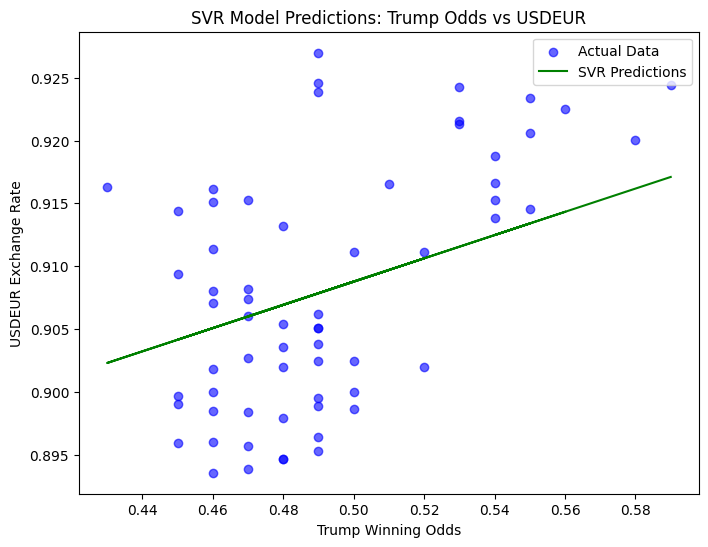

In [57]:
# Use the best SVR model (with the tuned parameters) to make predictions
y_pred_svr = best_svr_model.predict(X_svr_scaled)

# Plot the actual USDEUR data versus the predictions from the SVR model
plt.figure(figsize=(8, 6))

# Scatter plot of actual data
plt.scatter(X_svr, Y_svr, label='Actual Data', color='blue', alpha=0.6)

# Plot the SVR predictions
plt.plot(X_svr, y_pred_svr, label='SVR Predictions', color='green')

# Add labels and legend
plt.xlabel("Trump Winning Odds")
plt.ylabel("USDEUR Exchange Rate")
plt.title("SVR Model Predictions: Trump Odds vs USDEUR")
plt.legend()

# Show the plot
plt.show()


In [58]:
from sklearn.metrics import mean_squared_error, r2_score

# Calculate Mean Squared Error (MSE) and R-squared to assess model performance
mse_svr = mean_squared_error(Y_svr, y_pred_svr)
r2_svr = r2_score(Y_svr, y_pred_svr)

# Extract the number of support vectors used in the model
num_support_vectors = len(best_svr_model.support_)

# Display the results
mse_svr, r2_svr, num_support_vectors


(6.901128183025639e-05, 0.25592123813463097, 17)

In [59]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

# Prepare the data (Trump odds as X, USDEUR as Y)
X_xgb = merged_df[['Trump']].values  # Trump's odds as independent variable
Y_xgb = merged_df['USDEUR'].values   # USDEUR as the dependent variable

# Scale the data
scaler_xgb = StandardScaler()
X_xgb_scaled = scaler_xgb.fit_transform(X_xgb)

# Initialize the XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300]
}

# Set up GridSearchCV for tuning hyperparameters
grid_search_xgb = GridSearchCV(xgb_model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the XGBoost model with grid search
grid_search_xgb.fit(X_xgb_scaled, Y_xgb)

# Get the best parameters and the best model from grid search
best_xgb_model = grid_search_xgb.best_estimator_
best_params_xgb = grid_search_xgb.best_params_

# Output the best parameters
print("Best Parameters for XGBoost:", best_params_xgb)

# Use the best model to make predictions and evaluate its performance
y_pred_xgb = best_xgb_model.predict(X_xgb_scaled)

# You can then calculate metrics like MSE and R-squared, similar to how we did with SVR and GPR


Best Parameters for XGBoost: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


XGBoost Model Performance:
Mean Squared Error: 5.7070076830181784e-05
R-squared: 0.38467115837941857


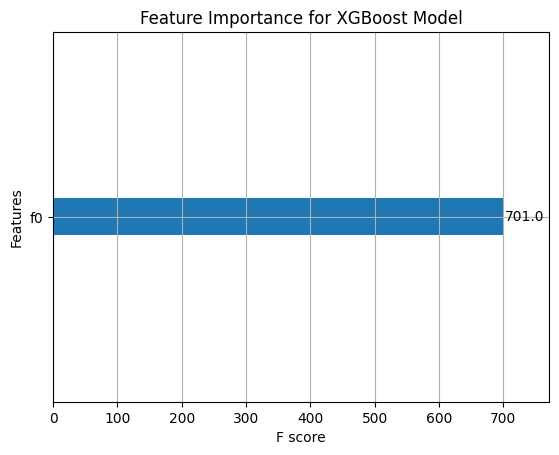

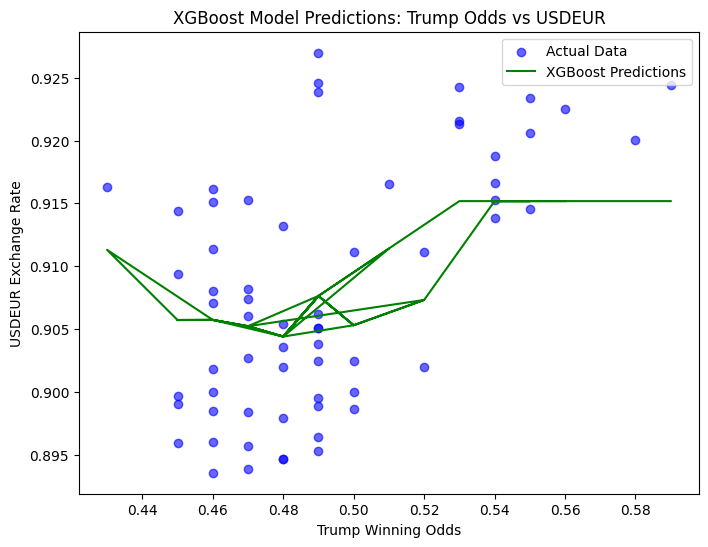

In [62]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Prepare the data (Trump odds as X, USDEUR as Y)
X_xgb = merged_df[['Trump']].values  # Trump's odds as independent variable
Y_xgb = merged_df['USDEUR'].values   # USDEUR as the dependent variable

# Scale the data
scaler_xgb = StandardScaler()
X_xgb_scaled = scaler_xgb.fit_transform(X_xgb)

# Initialize the XGBoost model with the best parameters
best_xgb_model = xgb.XGBRegressor(learning_rate=0.01, max_depth=5, n_estimators=100, objective='reg:squarederror', random_state=42)

# Fit the model on the scaled data
best_xgb_model.fit(X_xgb_scaled, Y_xgb)

# Make predictions using the fitted model
y_pred_xgb = best_xgb_model.predict(X_xgb_scaled)

# Evaluate the model's performance using Mean Squared Error (MSE) and R-squared
mse_xgb = mean_squared_error(Y_xgb, y_pred_xgb)
r2_xgb = r2_score(Y_xgb, y_pred_xgb)

# Print evaluation metrics
print(f"XGBoost Model Performance:\nMean Squared Error: {mse_xgb}\nR-squared: {r2_xgb}")

# Feature Importance
xgb.plot_importance(best_xgb_model, importance_type='weight')
plt.title("Feature Importance for XGBoost Model")
plt.show()

# Plot the actual vs predicted values
plt.figure(figsize=(8, 6))
plt.scatter(X_xgb, Y_xgb, label='Actual Data', color='blue', alpha=0.6)
plt.plot(X_xgb, y_pred_xgb, label='XGBoost Predictions', color='green')
plt.xlabel("Trump Winning Odds")
plt.ylabel("USDEUR Exchange Rate")
plt.title("XGBoost Model Predictions: Trump Odds vs USDEUR")
plt.legend()
plt.show()
